# Unsupervised Bayesian Anomaly Detection Using Beta Binomial Distribution

This notebook goes through an example of how one could use a bayesian framework to do unsupervised anomaly detection. In this particular example, we will consider medical coding behaviors from doctor office visits for evaluation and management services.

**Note that all data and results in this notebook are synthetic!** To see the data generation process, please see `/data/generate_data.ipynb`.

What is an E/M code?
1. E/M coding is the process by which physician-patient encounters are translated into five digit CPT codes to facilitate billing.
2. There are many attributes of the encounter that factor into the level of coding
    1. History
    2. Examination
    3. Medical decision making
    4. Counseling
    5. Coordination of care
    6. Nature of presenting problem
    7. Time (spent with patient)
    
The first three (history, examination, medical decision making) are considered the key components that determine the level of an E/M code.

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import sqlalchemy as sa
from random import randint
import statsmodels.formula.api as sm

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.lines as mlines
matplotlib.rcParams['figure.figsize'] = (10, 6)

sys.path.append('../../../')
import analysis as an
import em_codes as em

pd.options.mode.chained_assignment = None  # default='warn'

# Create DB Engine
db_url = 'postgres://localhost:5432/VincentLa'
db_engine = sa.create_engine(db_url)
conn = db_engine.connect()
conn.execute('CREATE SCHEMA IF NOT EXISTS tutorial_data_ingest;')
metadata = sa.MetaData(bind=conn)

# Define EM code groups
OFFICE_EST_PATIENT = [1, 2, 3, 4, 5]

claim_lines = sa.Table(
    'claim_lines',
    metadata,
    schema='tutorial_data_ingest',
    autoload=True
)

claims = pd.read_sql(em.get_claims_base_data(claim_lines, OFFICE_EST_PATIENT), conn)
groupings = claims[['servicing_provider_npi', 'specialty']]
groupings['group'] = groupings.specialty
groupings = groupings.drop_duplicates().reset_index(drop=True)

rename_columns = {'observations': 'number_of_encounters',
                  'successes': 'level_5_codes',
                  'group': 'provider_specialty',
                  'regressed_prob': 'expected_proportion'}
costs = claims[['servicing_provider_npi', 'paid_amount']].groupby(['servicing_provider_npi']).sum()

In [2]:
result_output, distribution_values_output = an.run(conn, claim_lines, OFFICE_EST_PATIENT)
results = result_output['All']
results = results[[
    'observations',
    'successes',
    'pct_high_encounters',
    'group',
    'regressed_prob',
    'prob_above_average',
]]
results.rename(columns=rename_columns, inplace=True)
results = results.merge(costs, left_index=True, right_index=True)

In [3]:
result_output_spec, distribution_values_output_spec = an.run(conn, claim_lines, OFFICE_EST_PATIENT, groupings)
mylist = list(result_output_spec.values())
results_spec = pd.concat(mylist)
results_spec = results_spec[[
    'observations',
    'successes',
    'pct_high_encounters',
    'group',
    'regressed_prob',
    'prob_above_average',
    'a',
    'b',
]]
results_spec.rename(columns=rename_columns, inplace=True)
results_spec = results_spec.merge(costs, left_index=True, right_index=True)

# Exploration

The data generated here is synthetic, but is modeled off of realistic assumptions. In this dataset we have
1. Only 5 procedures (5 different levels of office E/M codes)
2. ~250,000 encounters
3. ~1,500 providers
4. ~$30,000,000 in claims (E/M only)

This approximately fits the description of a dozen counties covering tens of thousands of lives.

In [4]:
summary = {
    'Number of Encounters': [claims.shape[0]],
    'Number of Providers': [claims.servicing_provider_npi.nunique()],
    'Number of Distinct Procedures': [claims.procedure_code.nunique()],
    'Total Cost': [claims.paid_amount.sum()]
}
summary = pd.DataFrame(summary)
summary

,Number of Distinct Procedures,Number of Encounters,Number of Providers,Total Cost
0,5,276728,1498,33459150


We've generated only 5 different types of procedure codes in this data set. In reality, there are many types of E/M codes. In this case, we only focus on one type.

In [5]:
claims[['procedure_code', 'procedure_name']].drop_duplicates().sort_values('procedure_code').reset_index(drop=True)

,procedure_code,procedure_name
0,1,"E/M, Lowest Intensity"
1,2,"E/M, Second Lowest Intensity"
2,3,"E/M, Medium Intensity"
3,4,"E/M, High Intensity"
4,5,"E/M, Highest Intensity"


Most doctors bill between 50 and 300 encounters in this data set. There is also a "spike" in the number of providers who bill very few claims. This is common in an HMO (or even PPO) setting for a payor because most claims are driven through in-network providers, but there are out-of-network providers who may see a small number of beneficiaries.

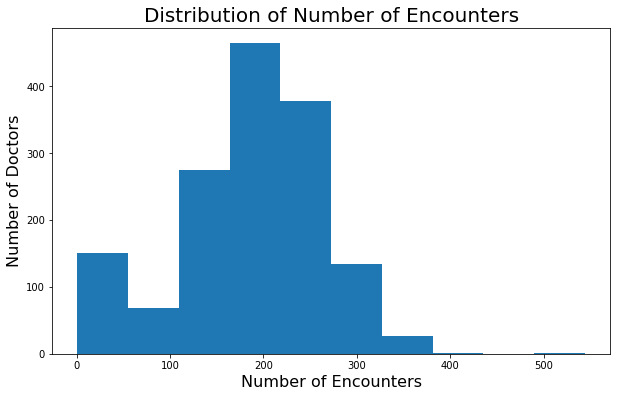

In [6]:
number_of_encounters = claims.groupby('servicing_provider_npi').size()
plt.hist(number_of_encounters)
plt.ylabel('Number of Doctors', fontsize=16)
plt.xlabel('Number of Encounters', fontsize=16)
plt.title('Distribution of Number of Encounters', fontsize=20)
plt.show()

Let's now look at the overall distribution of intensities. We see that in the aggregate, the most common codes are levels 3 and 4. There are very few level 1's. A bit more level 2's, and more level 5's. However, notice that the number of encounters billed as level 5's are much lower than level 3's and 4's.

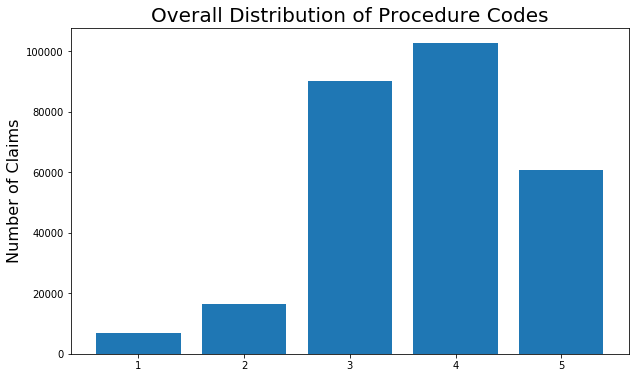

In [7]:
codes = claims.groupby('procedure_code').size().index
number_of_encounters = claims.groupby('procedure_code').size()
plt.bar(codes, number_of_encounters, align='center')
plt.xticks(codes, codes)
plt.ylabel('Number of Claims', fontsize=16)
plt.title('Overall Distribution of Procedure Codes', fontsize=20)
plt.show()

Next, we see that there are **three** distinct "clusters" of providers.

1. The majority of providers bill level 5 E/M codes very infrequently, on average about **10 percent** of the time.
2. The minority of providers bill level 5 E/M codes at a slightly higher rate, at around **30 percent** of the time.
3. The extreme outliers bill extremely high proportion of level 5 E/M codes, ranging from **50 to 95 percent** of the time.

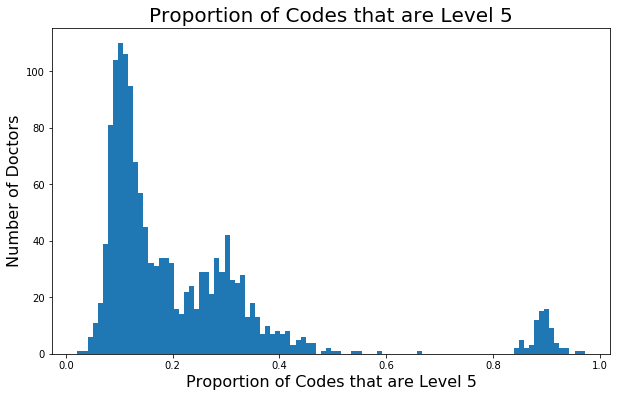

In [8]:
plt.hist(result_output['All'].pct_high_encounters, bins=100)
plt.ylabel('Number of Doctors', fontsize=16)
plt.xlabel('Proportion of Codes that are Level 5', fontsize=16)
plt.title('Proportion of Codes that are Level 5', fontsize=20)
plt.show()

# Anomaly Detection Results

### Lowest Hanging Fruit: Extreme Outliers

From the previous visualization, we saw three "clusters" of providers. As you can see below, the vast majority of the providers are in the first cluster, a relatively small amount are in the second cluster, and very few are in the third cluster of extreme outliers.

In [9]:
cluster1 = results.loc[(results.pct_high_encounters >= 0) & (results.pct_high_encounters <= 0.2)]
cluster2 = results.loc[(results.pct_high_encounters > 0.2) & (results.pct_high_encounters <= 0.6)]
cluster3 = results.loc[(results.pct_high_encounters > 0.6) & (results.pct_high_encounters <= 1)]

cluster_summary = pd.DataFrame({
    'Number of Providers': [cluster1.shape[0], cluster2.shape[0], cluster3.shape[0]],
    'Average Proportion of Level 5 Billed': [cluster1.pct_high_encounters.mean(),
                                             cluster2.pct_high_encounters.mean(),
                                             cluster3.pct_high_encounters.mean()],
    'Total Cost': [cluster1.paid_amount.sum(),
                   cluster2.paid_amount.sum(),
                   cluster3.paid_amount.sum()]
}, index=['Cluster 1: Normal Coders', 'Cluster 2: Higher Coders', 'Cluster 3: Extreme Outliers'])
cluster_summary['Percentage of Providers'] = cluster_summary['Number of Providers'] / cluster_summary['Number of Providers'].sum()
cluster_summary['Percentage of Total Cost'] = cluster_summary['Total Cost'] / cluster_summary['Total Cost'].sum()
cluster_summary

,Average Proportion of Level 5 Billed,Number of Providers,Total Cost,Percentage of Providers,Percentage of Total Cost
Cluster 1: Normal Coders,0.119313,894,18337090,0.614011,0.548531
Cluster 2: Higher Coders,0.303188,487,11953810,0.334478,0.357583
Cluster 3: Extreme Outliers,0.892144,75,3138530,0.051511,0.093885


As the lowest hanging fruit, I would first work with the third cluster of "extreme outliers". These providers seem to be billing at a much higher rate compared to others and are immediately suspicious irregardless of external possible explanations such as patient demographics, population risk, etc.

In addition, the number of providers in this third cluster are about 5 percent of all providers, but are associated with almost 10 percent of total cost. This would be the lowest hanging fruit to work with subject matter experts to review medical charts in more detail and investigate more.

Also to note is that in this synthetic data, I only included claims for E/M codes. In reality, we would see other much more expensive procedures being billed, and to the extent that upcoding E/M behavior is correlated with other potential FWA activity, these providers would be well worth investigating.

In my prior experience working with real data, simple ordering by level 5 codes and returning outliers yields non-trivial returns. For example, in several cases, providers who consistently bill at level 5's may be using a certain EMR system with templates that automatically bill at a certain level. Of course, further discussion is required to determine root cause and plan of action.


In [10]:
cluster3[['number_of_encounters',
          'level_5_codes',
          'pct_high_encounters',
          'paid_amount']].sort_values(by=['pct_high_encounters'], ascending=False).head(20)

,number_of_encounters,level_5_codes,pct_high_encounters,paid_amount
servicing_provider_npi,,,,
Dr. Stephanie Gagnon,144.0,140.0,0.972222,32440
Dr. Louis Kerr,110.0,105.0,0.954545,24370
Dr. Preston Winters,158.0,149.0,0.943038,35010
Dr. Jennifer Engle,131.0,123.0,0.938931,28750
Dr. Timothy Beddo,181.0,169.0,0.933702,39780
Dr. James Levine,135.0,126.0,0.933333,29550
Dr. Sherman Brown,167.0,154.0,0.922156,36010
Dr. Frederick Thomas,201.0,185.0,0.920398,43740
Dr. Emily Niedzwiecki,256.0,235.0,0.917969,55570


Above are the top 20 providers who look like extreme outliers.

### Digging Deeper: Identifying Outliers Beyond the Extremes

There are many nuances and caveats we need to keep in mind in this analysis. The main one is how do we differentiate between different patient characteristics across providers that may explain differences in coding patterns. There are many ways we can cut the data including:
1. **Provider Specialty**
2. Patient Risk
3. Geographical Areas

In this case study, we'll take a look at provider specialties. In a full analysis, it would be great to cut the data in different ways. This will also help us tease out spurious correlations vs meaningful signal.

First, let's look at the distribution of provider specialties among our doctors. In this synthetic data set, there are only 4 specialties:
1. Primary Care Providers (the majority)
2. Cardiologists
3. Infectious Disease
4. Other Specialties

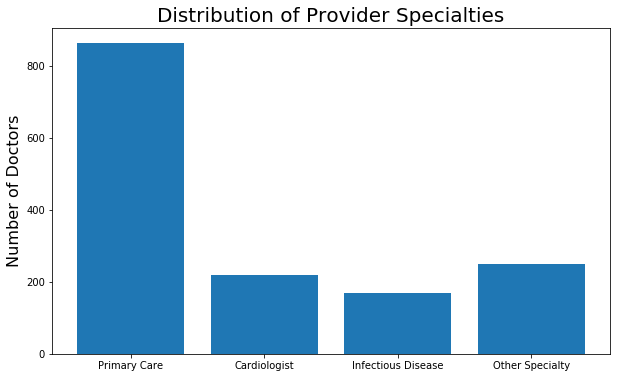

In [11]:
# X-axis needs to be numeric for matplotlib
specialties = claims.groupby('specialty').servicing_provider_npi.nunique().index
num_doctors = claims.groupby('specialty').servicing_provider_npi.nunique()
specialties_num = {
    'Primary Care': 0,
    'Cardiologist': 1,
    'Infectious Disease': 2,
    'Other Specialty': 3,
}
plt.bar([specialties_num[specialties[0]],
            specialties_num[specialties[1]],
            specialties_num[specialties[2]],
            specialties_num[specialties[3]]], list(num_doctors))
plt.xticks([specialties_num[specialties[0]],
            specialties_num[specialties[1]],
            specialties_num[specialties[2]],
            specialties_num[specialties[3]]], specialties)
plt.ylabel('Number of Doctors', fontsize=16)
plt.title('Distribution of Provider Specialties', fontsize=20)
plt.show()

The majority of doctors in our data set are primary care doctors. Looking at the distribution of proportion of level 5 coded, we can definitely see that there is a significant difference by provider type. Cardiologists tend to code the most level 5 codes and primary care providers tend to code the least.

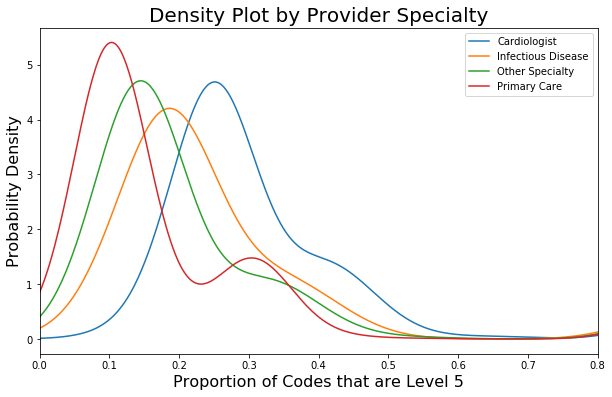

In [12]:
results_spec.groupby('provider_specialty')['pct_high_encounters']\
            .plot(kind='density', legend=True, xlim=(0, 0.8))
plt.title('Density Plot by Provider Specialty', fontsize=20)
plt.ylabel('Probability Density', fontsize=16)
plt.xlabel('Proportion of Codes that are Level 5', fontsize=16)
plt.show()

We can recreate an earlier distribution about the distribution of codes billed as level 5's, but cut by provider specialty.

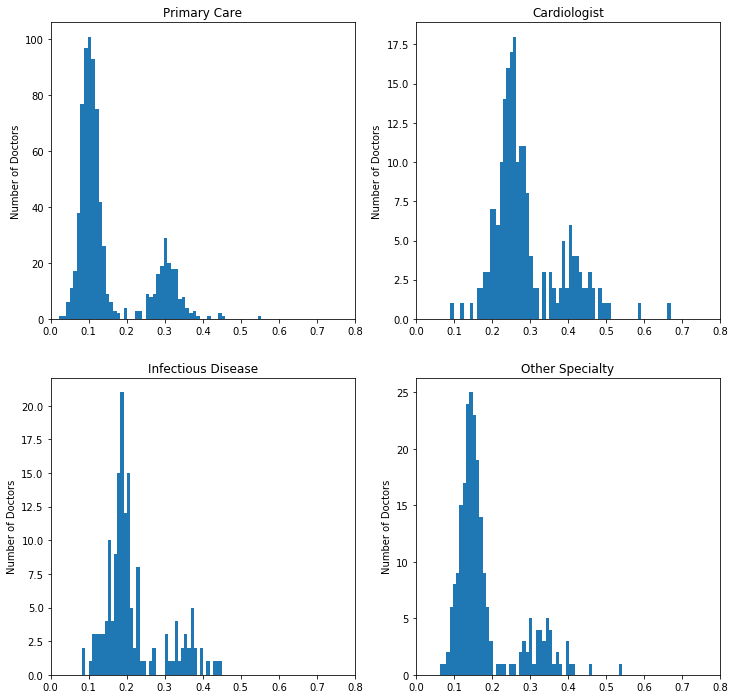

In [13]:
fig = plt.figure(figsize=(12, 12))
gs1 = gridspec.GridSpec(2, 2)
ax_list = [fig.add_subplot(ss) for ss in gs1]
for g, dfg in results_spec.groupby('provider_specialty'):
    ax = ax_list[specialties_num[g]]
    ax.set_title(g)
    ax.set_xlim(0, 0.8)
    ax.set_ylabel('Number of Doctors')
    ax.hist(dfg.pct_high_encounters, bins=100)

### The Beta Binomial Model

At this point, we could group providers by their specialties and rank order a list of "suspicious" providers using the proportion of codes billed as level 5's. In addition, we would iterate further by cutting, slicing, and visualizing the data in different ways to include other features such as: patient risk, geography, practice type, etc.

There are many ways to do this; in this case study, I will introduce the **beta binomial** model. The chief advantages of using a beta binomial model are that it gives us structured ways to reason through
1. Controlling for other features that can affect provider billing behavior
2. Controlling for differences in provider sample size (patient panel)

The basic intuition behind the beta binomial model is that to control for other features that can affect provider behvario, first group the data set using whichever features you wish. This includes patient panel risk, geography, provider specialty, practice type. The model will then use all the providers within the **same** grouping to fit a estimate of the distribution of proportion of level 5 codes. This will represent the distribution for the average provider within that grouping. Then, you compare that to the distribution of any particular provider; if the distributions are significantly different than you can conclude that the particular provider is significantly different from his/her peers.

This also gives a way to naturally control for differences in provider patient panel size (which using simple proportions does not). We'll see an example of this later, but intuitively, lower sample size will result in more uncertainty in the estimate for that particular provider. 

I'll skip over the technical details for now, but happy to answer additional questions!




First, let's look at an example of how the beta binomial model helps us with small sample sizes.

In [14]:
pd.concat([
    results_spec.loc[(results_spec.pct_high_encounters >= 0.5) & (results_spec.number_of_encounters <= 6)]\
            .sort_values(by=['number_of_encounters'], ascending=True).head(2),
    results_spec.loc[(results_spec.pct_high_encounters >= 0.5) & (results_spec.number_of_encounters >= 70)]\
            .sort_values(by=['number_of_encounters'], ascending=True).head(2)])[['number_of_encounters',
                                                                                 'level_5_codes',
                                                                                 'pct_high_encounters',
                                                                                 'provider_specialty',
                                                                                 'expected_proportion',
                                                                                 'prob_above_average',]]

,number_of_encounters,level_5_codes,pct_high_encounters,provider_specialty,expected_proportion,prob_above_average
servicing_provider_npi,,,,,,
Dr. Margaret Vandergriff,3.0,2.0,0.666667,Cardiologist,0.420425,0.66776
Dr. Louis Kerr,110.0,105.0,0.954545,Cardiologist,0.910735,0.99991
Dr. Judy Rucker,114.0,57.0,0.500000,Cardiologist,0.488547,0.82509


Next, we look at a couple of visualizations of how the beta binomial model can control for various features.

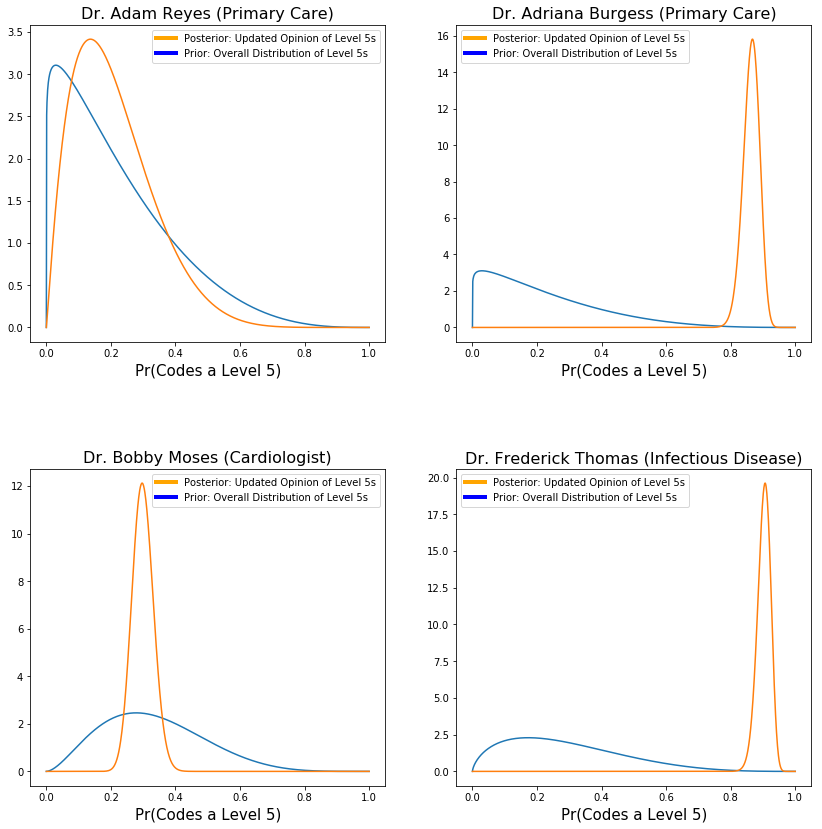

In [15]:
# Maybe plot one for each provider specialty?
fig = plt.figure(figsize=(14, 14))
gs1 = gridspec.GridSpec(2, 2)
gs1.update(hspace=.4)
ax_list = [fig.add_subplot(ss) for ss in gs1]

npis = results.sort_values(['prob_above_average'], ascending=False).head(4).index
npis = pd.concat([
    results_spec.loc[(results_spec.provider_specialty == 'Primary Care') & (results_spec.prob_above_average >= 0.4) & (results_spec.prob_above_average <= 0.6)].head(1),
    results_spec.loc[(results_spec.provider_specialty == 'Primary Care') & (results_spec.prob_above_average >= 0.8)].head(1),
    results_spec.loc[(results_spec.provider_specialty == 'Cardiologist') & (results_spec.prob_above_average >= 0.4) & (results_spec.prob_above_average <= 0.6)].head(1),
    results_spec.loc[(results_spec.provider_specialty == 'Infectious Disease') & (results_spec.prob_above_average >= 0.8)].head(1),
]).index

specialty_examples = ['Primary Care', 'Primary Care', 'Cardiologist', 'Infectious Disease']
for i,npi in enumerate(npis):
    ax=ax_list[i]
    distribution_values = distribution_values_output_spec[specialty_examples[i]]
    ax.plot(distribution_values['prior'][0], distribution_values['prior'][1])
    ax.plot(distribution_values[npi][0], distribution_values[npi][1])
    ax.set_title('{} ({})'.format(npi, specialty_examples[i]), fontsize=16)
    ax.set_xlabel('Pr(Codes a Level 5)', fontsize=15)
    posterior = mlines.Line2D([], [], color='orange', label='Posterior: Updated Opinion of Level 5s', linewidth=4)
    prior = mlines.Line2D([], [], color='blue', label='Prior: Overall Distribution of Level 5s', linewidth=4)

    ax.legend(handles=[posterior, prior], fontsize=10)

# Conclusion

In this case study, we examined how to detect anomalies in Evaluation and Management upcoding behavior using claims data. While the data and results presented here are synthetic, both are grounded in realistic patterns from CMS data.

We can look at the providers who are above 80% probability above average.

In [16]:
cluster1 = results_spec.loc[(results_spec.prob_above_average >= 0.8)]
cluster2 = results_spec.loc[(results_spec.prob_above_average < 0.8)]

cluster_summary = pd.DataFrame({
    'Number of Providers': [cluster1.shape[0], cluster2.shape[0]],
    'Average Proportion of Level 5 Billed': [cluster1.pct_high_encounters.mean(),
                                             cluster2.pct_high_encounters.mean(),],
    'Total Cost': [cluster1.paid_amount.sum(),
                   cluster2.paid_amount.sum(),]
}, index=['Cluster 1: Potential Upcoders', 'Cluster 2: Non-Upcoders'])
cluster_summary['Percentage of Providers'] = cluster_summary['Number of Providers'] / cluster_summary['Number of Providers'].sum()
cluster_summary['Percentage of Total Cost'] = cluster_summary['Total Cost'] / cluster_summary['Total Cost'].sum()
cluster_summary

,Average Proportion of Level 5 Billed,Number of Providers,Total Cost,Percentage of Providers,Percentage of Total Cost
Cluster 1: Potential Upcoders,0.801488,93,3614780,0.063786,0.107835
Cluster 2: Non-Upcoders,0.180883,1365,29906490,0.936214,0.892165


Overall, from this synthetic data, it looks like the the cluster of potential upcoders make up about 6 percent of total providers but are associated with about 10 percent of total costs. This would be just the first step of analysis. From here I see the next steps as:

1. Working with SMEs to tackle the lowest hanging fruit.
    1. Start with extreme outliers
    2. From there work down the list.
2. In addition to working with the SMEs, there are many things on the data side to follow up on.
    1. Patient demographic and health risk characteristics?
    2. Local health system characteristics
3. This synthetic data showed proof of concept and specifically only had E/M codes. However, in reality, upcoding E/M behavior is potentially also correlated with other FWA behavior. Thus, the costs shown here are not the entire picture. I would want to follow up on other types of claims from these suspicious providers.

# Appendix: Validating Results

How do we validate the results of our analysis? For example, one question we might have is how do we know whether the results of our analysis are due to just spurious noise, or if there's real signal here?

In this section, we talk about one very intuitive approach to validate our results. As this is unsupervised learning, it is not possible to do a traditional 'cross-validation' approach. However, one can do something similar in spirit. Below, we split out data set in half randomly by taking separating all even `personid` from odd `personid`. We then run our analysis over each of the data sets separately and return the ranking of providers in each. We then correlate the rankings obtained in the separate data sets. If rankings are highly correlated, that's decent evidence that there is real signal. If the rankings are not correlated, one might conclude that results are really due to statistical noise.

In [17]:
columns = [
    claim_lines.c.personid,
    claim_lines.c.servicing_provider_npi,
    claim_lines.c.procedure_code,
    claim_lines.c.procedure_name,
    claim_lines.c.specialty,
    claim_lines.c.paid_amount,
]
claim_lines_1 = (
    sa.select(columns).
    select_from(claim_lines).
    where(claim_lines.c.personid % 2 == 1)
).correlate(None).alias('claim_lines_1')

claim_lines_2 = (
    sa.select(columns).
    select_from(claim_lines).
    where(claim_lines.c.personid % 2 == 0)
).correlate(None).alias('claim_lines_1')

In [18]:
result_output_1, distribution_values_output_1 = an.run(conn, claim_lines_1, OFFICE_EST_PATIENT)
result_output_2, distribution_values_output_2 = an.run(conn, claim_lines_2, OFFICE_EST_PATIENT)

In [19]:
output1 = result_output_1['All']
output2 = result_output_2['All']

In [20]:
combined = output1.merge(output2, left_index=True, right_index=True)

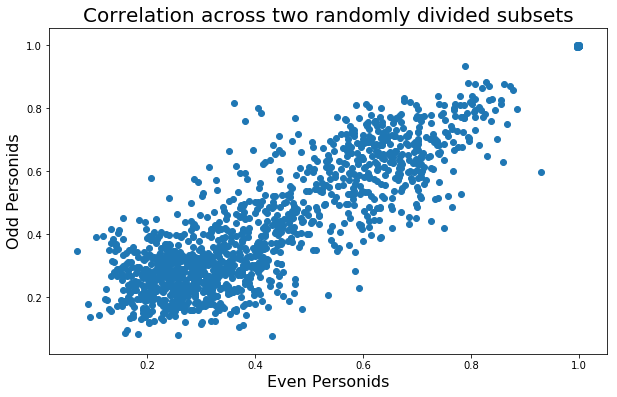

In [21]:
plt.scatter(combined.prob_above_average_x, combined.prob_above_average_y)
plt.ylabel('Odd Personids', fontsize=16)
plt.xlabel('Even Personids', fontsize=16)
plt.title('Correlation across two randomly divided subsets', fontsize=20)
plt.show()

We plot the probability above average returned for each doctor across the two randomly divided subsets (using even/odd personids). Notice that while the correlation isn't perfectly equal to 1 (and we should not expect this to be the case), there does seem to be meaningful correlation in the two randomly divided subsets. This provides some evidence that these providers actually are associated with more level 5 codes as opposed to the pattern being generated by random noise.